In [61]:
import pandas as pd

In [62]:
df = pd.read_csv(r"data\vgsales_clean.csv")

In [63]:
df

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df_pulito = df[df['Year_of_Release'] <= 2015]  # Includi tutti i dati fino al 2015 (pre-2000 inclusi)

# Game Analytics: Video Game Sales & Success Prediction

## Obiettivi
1. **Analisi per Piattaforma e Genere**: Quale combinazione ha performato meglio?
2. **Impatto Recensioni**: Quanto contano critica e rating sul successo?
3. **Hit Prediction ML**: Stimare la probabilità di raggiungere ≥1M copie
4. **Natural Language Query**: Interrogare i dati in italiano

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Setup visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Esplorazione Dati Base

In [66]:
print(f"Dataset Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nStatistiche Vendite Globali:\n{df['Global_Sales'].describe()}")

Dataset Shape: (16719, 16)

Data Types:
Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

Missing Values:
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

Statistiche Vendite Globali:
count    16719.000000
mean         0.533543
std          1.547935
min 

## 2. Piattaforme e Generi: Cosa Ha Funzionato?

In [67]:
# Top 10 Piattaforme per Vendite Globali
platform_sales = df.groupby('Platform')['Global_Sales'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
print("TOP PIATTAFORME (per Vendite Globali Totali):")
print(platform_sales.head(10))

# Top 10 Generi
genre_sales = df.groupby('Genre')['Global_Sales'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
print("\n\nTOP GENERI (per Vendite Globali Totali):")
print(genre_sales)

TOP PIATTAFORME (per Vendite Globali Totali):
              sum  count      mean
Platform                          
PS2       1255.64   2161  0.581046
X360       971.63   1262  0.769913
PS3        939.43   1331  0.705808
Wii        908.13   1320  0.687977
DS         807.10   2152  0.375046
PS         730.68   1197  0.610426
GBA        318.50    822  0.387470
PS4        314.23    393  0.799567
PSP        294.30   1209  0.243424
PC         260.30    974  0.267248


TOP GENERI (per Vendite Globali Totali):
                  sum  count      mean
Genre                                 
Action        1745.27   3370  0.517884
Sports        1332.00   2348  0.567291
Shooter       1052.94   1323  0.795873
Role-Playing   934.40   1500  0.622933
Platform       828.08    888  0.932523
Misc           803.18   1750  0.458960
Racing         728.90   1249  0.583587
Fighting       447.48    849  0.527067
Simulation     390.42    874  0.446705
Puzzle         243.02    580  0.419000
Adventure      237.69  

In [68]:
# Heatmap Interattiva Plotly con Menu a Tendina: Piattaforma vs Genere

from ipywidgets import Dropdown, interactive
import plotly.graph_objects as go

def create_interactive_heatmap_widget(period_name):
    """
    Crea heatmap interattiva Plotly normalizzata per genere
    """
    periods = {
        'Genesis Era (< 2000)': (1800, 1999),
        'Early Era (2000-2006)': (2000, 2006),
        'Peak Era (2007-2012)': (2007, 2012),
        'Modern Era (2013-2015)': (2013, 2015)
    }
    
    start_year, end_year = periods[period_name]
    df_period = df_pulito[(df_pulito['Year_of_Release'] >= start_year) & (df_pulito['Year_of_Release'] <= end_year)]
    
    if len(df_period) == 0:
        print(f"⚠️ Nessun dato disponibile per il periodo {start_year}-{end_year}")
        return
    
    # Pivot table
    platform_genre = df_period.pivot_table(
        values='Global_Sales', 
        index='Platform', 
        columns='Genre', 
        aggfunc='sum', 
        fill_value=0
    )
    
    # Normalizza per riga (% di vendite per genere su ogni piattaforma)
    platform_genre_norm = platform_genre.div(platform_genre.sum(axis=1), axis=0) * 100
    
    # Filtra solo top 10 piattaforme per leggibilità
    top_platforms = platform_genre_norm.sum(axis=1).nlargest(10).index
    platform_genre_norm = platform_genre_norm.loc[top_platforms]
    
    # Crea heatmap Plotly
    fig = go.Figure(data=go.Heatmap(
        z=platform_genre_norm.values,
        x=platform_genre_norm.columns,
        y=platform_genre_norm.index,
        colorscale='YlOrRd',
        text=np.round(platform_genre_norm.values, 1),
        texttemplate='%{text:.1f}%',
        textfont={"size": 10},
        colorbar=dict(title="% Vendite"),
        hovertemplate='<b>%{y}</b> - %{x}<br>Percentuale: %{text:.1f}%<extra></extra>'
    ))
    
    fig.update_layout(
        title=f'{period_name} - Piattaforma vs Genere: Percentuale Vendite',
        xaxis_title='Genere',
        yaxis_title='Piattaforma',
        height=600,
        width=1000,
        font=dict(size=11)
    )
    
    fig.show()
    print(f"\n✅ Heatmap: {period_name}")
    print(f"   Giochi analizzati: {len(df_period)}")
    print(f"   Vendite totali: {df_period['Global_Sales'].sum():.1f}M")

# Crea dropdown widget
period_dropdown = Dropdown(
    options=['Genesis Era (< 2000)', 'Early Era (2000-2006)', 'Peak Era (2007-2012)', 'Modern Era (2013-2015)'],
    value='Early Era (2000-2006)',
    description='Periodo:',
    style={'description_width': 'initial'},
)

print("🎮 MENU A TENDINA - Seleziona il Periodo Storico\n")

# Crea l'interfaccia interattiva
interactive_plot = interactive(create_interactive_heatmap_widget, period_name=period_dropdown)
display(interactive_plot)

🎮 MENU A TENDINA - Seleziona il Periodo Storico



interactive(children=(Dropdown(description='Periodo:', index=1, options=('Genesis Era (< 2000)', 'Early Era (2…

## Publisher Ranking: I Più Prolifici

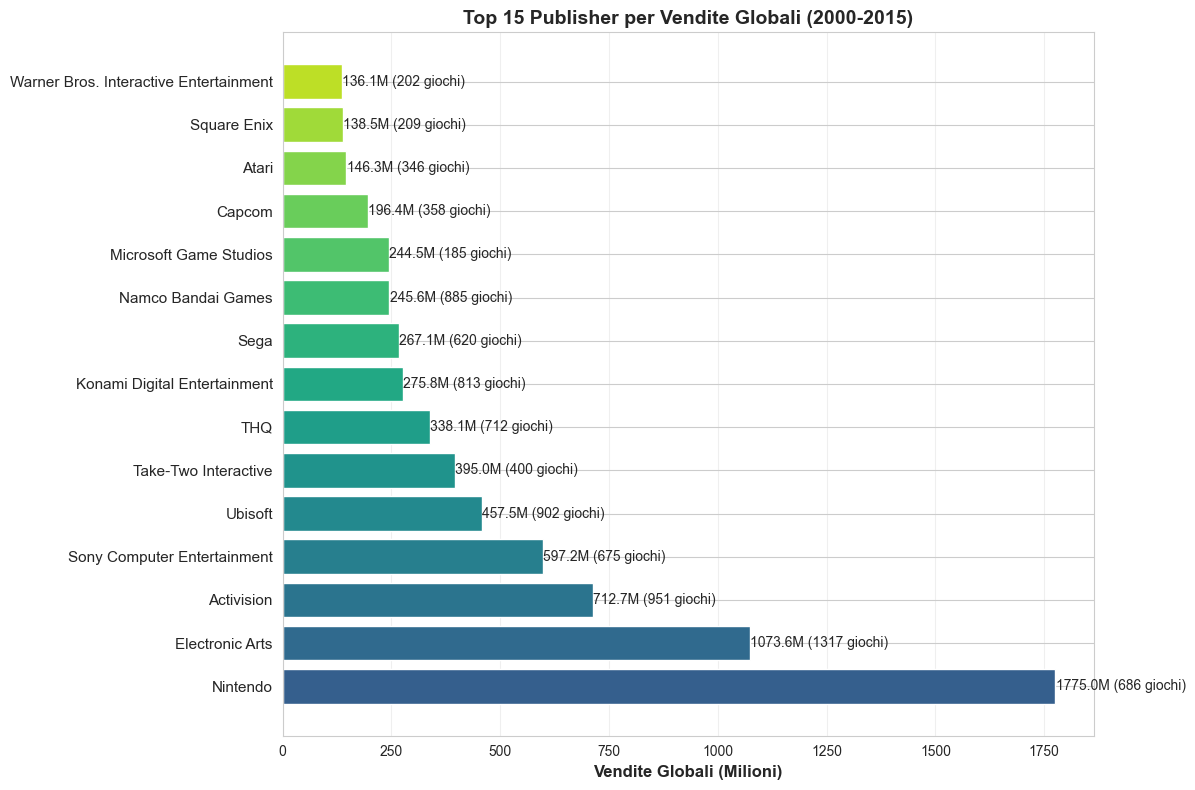

TOP 15 PUBLISHER (2000-2015):

                                            sum  count
Publisher                                             
Nintendo                                1774.98    686
Electronic Arts                         1073.57   1317
Activision                               712.66    951
Sony Computer Entertainment              597.20    675
Ubisoft                                  457.53    902
Take-Two Interactive                     395.00    400
THQ                                      338.11    712
Konami Digital Entertainment             275.78    813
Sega                                     267.07    620
Namco Bandai Games                       245.58    885
Microsoft Game Studios                   244.48    185
Capcom                                   196.36    358
Atari                                    146.31    346
Square Enix                              138.53    209
Warner Bros. Interactive Entertainment   136.05    202


In [69]:
# Top 15 Publisher per Vendite Globali (con df_pulito)
top_publishers = df_pulito.groupby('Publisher')['Global_Sales'].agg(['sum', 'count']).sort_values('sum', ascending=False).head(15)

# Grafico a barre orizzontali
fig, ax = plt.subplots(figsize=(12, 8))

# Ordinamento per valori per avere il più alto in fondo (visualizzazione migliore)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_publishers)))
ax.barh(range(len(top_publishers)), top_publishers['sum'].values, color=colors)

# Etichette asse Y
ax.set_yticks(range(len(top_publishers)))
ax.set_yticklabels(top_publishers.index, fontsize=11)

# Etichette assi
ax.set_xlabel('Vendite Globali (Milioni)', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Publisher per Vendite Globali (2000-2015)', fontsize=14, fontweight='bold')

# Aggiungi valori sulle barre
for i, (idx, row) in enumerate(top_publishers.iterrows()):
    ax.text(row['sum'] + 1, i, f"{row['sum']:.1f}M ({int(row['count'])} giochi)", 
            va='center', fontsize=10)

# Grid
ax.grid(True, alpha=0.3, axis='x')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

print("TOP 15 PUBLISHER (2000-2015):\n")
print(top_publishers)

## 3. Trend nel Tempo (Anno di Uscita)

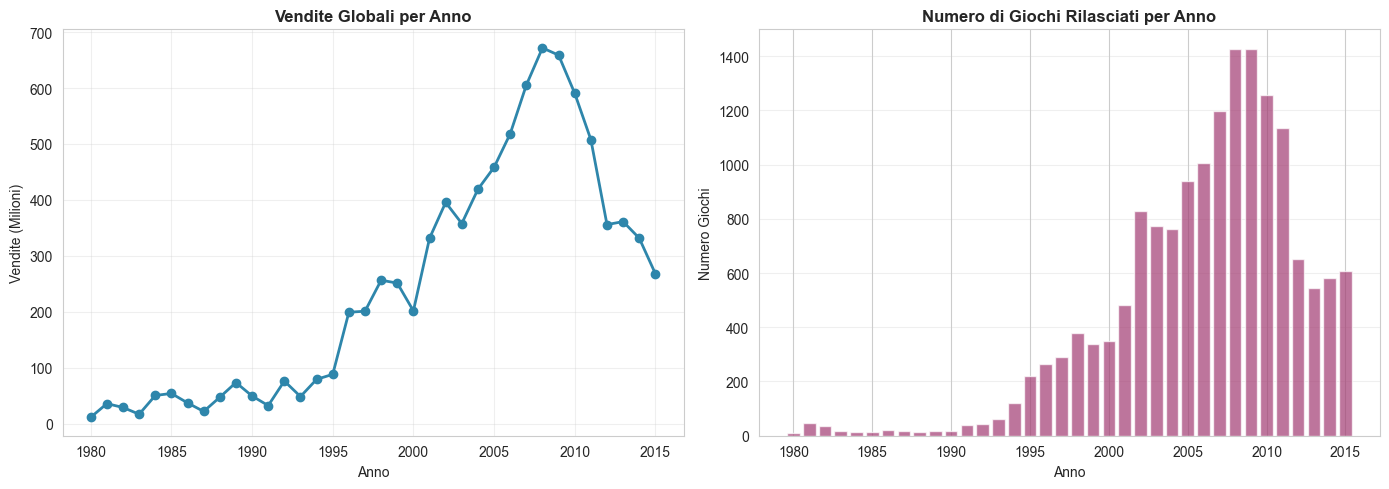

In [70]:
yearly_sales = df_pulito.groupby('Year_of_Release')['Global_Sales'].agg(['sum', 'count']).reset_index()
yearly_sales = yearly_sales[yearly_sales['Year_of_Release'].notna()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Vendite totali per anno
ax1.plot(yearly_sales['Year_of_Release'], yearly_sales['sum'], marker='o', linewidth=2, markersize=6, color='#2E86AB')
ax1.set_title('Vendite Globali per Anno', fontsize=12, fontweight='bold')
ax1.set_xlabel('Anno')
ax1.set_ylabel('Vendite (Milioni)')
ax1.grid(True, alpha=0.3)

# Numero di giochi per anno
ax2.bar(yearly_sales['Year_of_Release'], yearly_sales['count'], color='#A23B72', alpha=0.7)
ax2.set_title('Numero di Giochi Rilasciati per Anno', fontsize=12, fontweight='bold')
ax2.set_xlabel('Anno')
ax2.set_ylabel('Numero Giochi')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3.5 Analisi Dati Mancanti: Rating e Recensioni

📊 ANALISI DATI MANCANTI - Rating e Recensioni
     Colonna  Mancanti  Totale  Percentuale  Disponibili  % Disponibili
Critic_Score      8193   15944        51.39         7751          48.61
Critic_Count      8193   15944        51.39         7751          48.61
  User_Score      6401   15944        40.15         9543          59.85
  User_Count      8743   15944        54.84         7201          45.16
      Rating      6456   15944        40.49         9488          59.51




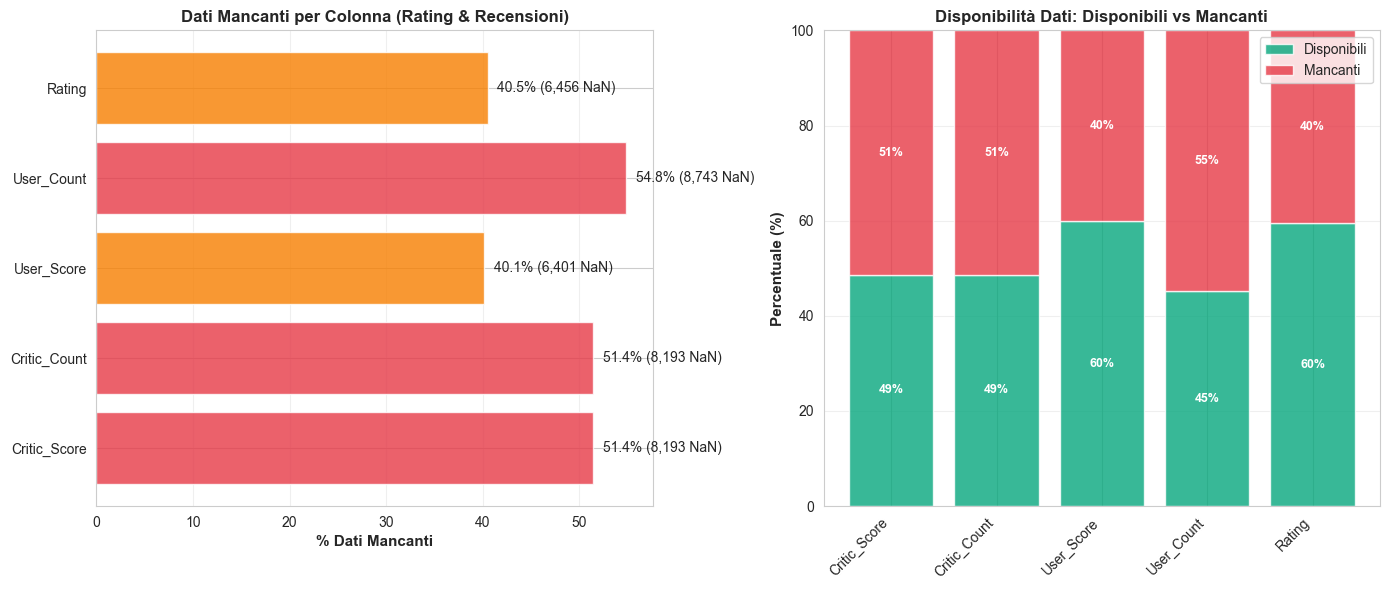


💡 KEY INSIGHTS:
--------------------------------------------------------------------------------
Critic_Score    → 7,751 disponibili  |   51.4% mancanti  | 🟠 SEVERO - Meno della metà dei dati disponibili
Critic_Count    → 7,751 disponibili  |   51.4% mancanti  | 🟠 SEVERO - Meno della metà dei dati disponibili
User_Score      → 9,543 disponibili  |   40.1% mancanti  | 🟡 MODERATO - Circa 1/4 dei dati mancanti
User_Count      → 7,201 disponibili  |   54.8% mancanti  | 🟠 SEVERO - Meno della metà dei dati disponibili
Rating          → 9,488 disponibili  |   40.5% mancanti  | 🟡 MODERATO - Circa 1/4 dei dati mancanti


In [76]:
# Analisi Dati Mancanti per Rating e Recensioni

# Colonne di interesse per rating e recensioni
rating_review_cols = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating']

# Calcola i dati mancanti in numeri assoluti e percentuale
missing_analysis = pd.DataFrame({
    'Colonna': rating_review_cols,
    'Mancanti': [df_pulito[col].isnull().sum() for col in rating_review_cols],
    'Totale': len(df_pulito),
})
missing_analysis['Percentuale'] = (missing_analysis['Mancanti'] / missing_analysis['Totale'] * 100).round(2)
missing_analysis['Disponibili'] = missing_analysis['Totale'] - missing_analysis['Mancanti']
missing_analysis['% Disponibili'] = (100 - missing_analysis['Percentuale']).round(2)

print("📊 ANALISI DATI MANCANTI - Rating e Recensioni")
print("=" * 80)
print(missing_analysis.to_string(index=False))
print("\n")

# Crea visualizzazione grafica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Grafico 1: Dati mancanti in percentuale
colors_missing = ['#E63946' if x > 50 else '#F77F00' if x > 20 else '#06A77D' for x in missing_analysis['Percentuale']]
ax1.barh(missing_analysis['Colonna'], missing_analysis['Percentuale'], color=colors_missing, alpha=0.8)
ax1.set_xlabel('% Dati Mancanti', fontsize=11, fontweight='bold')
ax1.set_title('Dati Mancanti per Colonna (Rating & Recensioni)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Aggiungi etichette con valori
for i, (col, pct, missing) in enumerate(zip(missing_analysis['Colonna'], missing_analysis['Percentuale'], missing_analysis['Mancanti'])):
    ax1.text(pct + 1, i, f"{pct:.1f}% ({missing:,} NaN)", va='center', fontsize=10)

# Grafico 2: Dati disponibili vs mancanti (stacked bar)
x_pos = range(len(missing_analysis))
ax2.bar(x_pos, missing_analysis['% Disponibili'], label='Disponibili', color='#06A77D', alpha=0.8)
ax2.bar(x_pos, missing_analysis['Percentuale'], bottom=missing_analysis['% Disponibili'], label='Mancanti', color='#E63946', alpha=0.8)

ax2.set_ylabel('Percentuale (%)', fontsize=11, fontweight='bold')
ax2.set_title('Disponibilità Dati: Disponibili vs Mancanti', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(missing_analysis['Colonna'], rotation=45, ha='right')
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim([0, 100])
ax2.grid(True, alpha=0.3, axis='y')

# Aggiungi percentuali sulle barre
for i, (avail, miss) in enumerate(zip(missing_analysis['% Disponibili'], missing_analysis['Percentuale'])):
    if avail > 5:
        ax2.text(i, avail/2, f"{avail:.0f}%", ha='center', va='center', fontweight='bold', color='white', fontsize=9)
    if miss > 5:
        ax2.text(i, avail + miss/2, f"{miss:.0f}%", ha='center', va='center', fontweight='bold', color='white', fontsize=9)

plt.tight_layout()
plt.show()

# Insights
print("\n💡 KEY INSIGHTS:")
print("-" * 80)
for idx, row in missing_analysis.iterrows():
    col = row['Colonna']
    pct_missing = row['Percentuale']
    disponibili = row['Disponibili']
    
    if pct_missing > 80:
        status = "🔴 CRITICO - Pochissimi dati disponibili"
    elif pct_missing > 50:
        status = "🟠 SEVERO - Meno della metà dei dati disponibili"
    elif pct_missing > 20:
        status = "🟡 MODERATO - Circa 1/4 dei dati mancanti"
    else:
        status = "🟢 BUONO - Copertura dati accettabile"
    
    print(f"{col:15} → {disponibili:5,} disponibili  |  {pct_missing:5.1f}% mancanti  | {status}")

print("=" * 80)